We will use PASCAL VOC 2012 dataset.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn

from xml.etree.ElementTree import parse


seed = 14
np.random.seed(seed)

/home/suchith/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def parse_voc_xml(root):
    # for the output, see the output of test.json in yolo folder.
    # you can find the xml file in annoations folder
    target = {}
    childrens = root.getchildren()
    if len(childrens) == 0:
        return {
            root.tag: root.text.strip()
        }
    else:
        for children in childrens:
            dc = parse_voc_xml(children)
            for key, val in dc.items():
                target[key] = target.get(key, []) + [val]
        # if the list has only one element
        target = {key: val[0] if len(val) == 1 else val for key, val in target.items()}
        return {
            root.tag: target
        }


def parse_xml(xmlpath):
    root = parse(xmlpath).getroot()
    target = parse_voc_xml(root)
    # here, object is always returned as list even for 1 element.
    if not isinstance(target["annotation"]["object"], list):
        target["annotation"]["object"] = [target["annotation"]["object"]]

    return target


def bndbox_to_list(bndbox):
    ans = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
    return list(map(int, ans))


def draw_bbox(image, boxes, names, random=True):
    img = np.copy(image)
    for name, box in zip(names, boxes):
        xmin, ymin, xmax, ymax = box
        if random:
            color = list(np.random.random(size=3)*256)
        else:
            color = [255, 0, 0]
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, name, (xmin + 2, ymin + 7), font, 0.5, color)
    
    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    plt.show()


def draw_anchor_centers(image, cx, cy):
    """
        cx : (n, n)
        cy : (n, n)
    """
    img = np.copy(image)
    m, n = cx.shape
    for i in range(m):
        for j in range(n):
            cv2.circle(img, (cx[i][j], cy[i][j]), radius=2, color=(0, 255, 255), thickness=1)

    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    plt.show()


def recal_bbox(boxes, initial_shape, final_shape):
    """
        boxes -> (N, 4) numpy array with order [xmin, ymin, xmax, ymax]
        initial_shape = [height, width]
        final_shape = [height, width]
    """
    hm = final_shape[0]/initial_shape[0]
    wm = final_shape[1]/initial_shape[1]
    
    m = np.array([[wm, hm, wm , hm]])
    return (boxes * m).astype(np.int64)


def get_anchor_height_width(areas, aspect_ratios):
    """
        areas : list of areas (let the length be n)
        aspect_ratios : list of aspect_ratios where aspect ratio is height / width (let the length be m)
        
        return array of size (m*n, 2) where first column is height and second column is width
    """
    out = np.meshgrid(areas, aspect_ratios)
    heights = np.sqrt(out[0] * out[1]).flatten()
    widths = np.sqrt(out[0] / out[1]).flatten()
    hw = np.stack([heights, widths], axis=1)
    return hw



# copied from : https://pytorch.org/vision/stable/_modules/torchvision/ops/boxes.html
# search for box_iou function.

def box_area(box):
    """
        box : (N, 4)
        out : (N, 1)
    """
    AREA = np.prod(box[:, 2:] - box[:, :2], axis=1, keepdims=True) # (N, 1)
    return AREA


def box_intersection_and_union_area(b1, b2):
    """
        b1 : (N, 4)
        b2 : (M, 4)
        
        out : (N, M)
    """
    # (N, 1) and (M, 1)
    a1 = box_area(b1)
    a2 = box_area(b2)

    # top left
    # maximum of (N, 1, 2) and (1, M, 2) gives output of (N, M, 2)
    tl = np.maximum(b1[:, None, :2], b2[None, :, :2])
    # bottom right
    # same as above (N, M, 2)
    br = np.minimum(b1[:, None, 2:], b2[None, :, 2:])

    # height width
    hw = br - tl  # (N, M, 2)
    hw = np.clip(hw, a_min=0, a_max=None)
    inter = hw[:, :, 0] * hw[:, :, 1] # (N, M)

    # union area = a1 + a2 - inter -> (N, M)
    union = a1 + np.transpose(a2) - inter

    return inter, union
    

def box_iou(b1, b2):
    """
        b1 : (N, 4)
        b2 : (M, 4)
        
        out : (N, M)
    """
    inter, union = box_intersection_and_union_area(b1, b2)

    # iou -> (N, M)
    iou = inter / union
    return iou


In [3]:
class Backbone(nn.Module):
    def __init__(self, backbone):
        super(Backbone, self).__init__()
        self.backbone = backbone

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        return x


class RegionProposalNetwork(nn.Module):
    def __init__(self, n, channels, k):
        super(RegionProposalNetwork, self).__init__()
        self.n = n
        self.channels = channels
        self.k = k
        
        self.conv = nn.Conv2d(self.channels, 256, kernel_size=(3, 3), stride=1, padding=1)
        self.cls = nn.Conv2d(256, 2*self.k, kernel_size=(1, 1), bias=False)
        self.reg = nn.Conv2d(256, 4*self.k, kernel_size=(1, 1), bias=False)
    
    def forward(self, x):
        out = self.conv(x)
        cls = self.cls(out)
        reg = self.reg(out)
        return cls, reg


In [4]:
# constants
image_size = (600, 600)

labels = [
            'aeroplane',
            'bicycle',
            'bird',
            'boat',
            'bottle',
            'bus',
            'car',
            'cat',
            'chair',
            'cow',
            'diningtable',
            'dog',
            'horse',
            'motorbike',
            'person',
            'pottedplant',
            'sheep',
            'sofa',
            'train',
            'tvmonitor'
        ]

areas = [64**2, 128**2, 256**2, 512**2]
# aspect ratio here is defined as ratio of height/width that is rows / columns
aspect_ratios = [1, 1/2, 2/1]

# foreground threshold in RPN
fg_iou_threshold = 0.7
# background threshold in RPN
bg_iou_threshold = 0.3

In [5]:
labels = sorted(labels)
class_to_idx = {cl: ix for ix, cl in enumerate(labels)}
idx_to_class = {ix: cl for ix, cl in enumerate(labels)}
print(class_to_idx)

{'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


(377, 500, 3)
[[  1 156 500 377]
 [ 42  33 108 104]
 [ 20   1 331 185]
 [150   5 490 373]]
['diningtable', 'person', 'person', 'person']


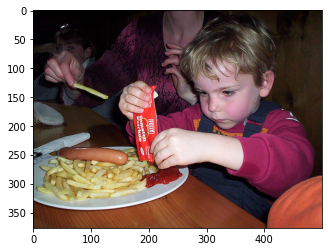

In [6]:
image_path = "data/VOCdevkit/VOC2012/JPEGImages/2011_002985.jpg"
annotation_path = "data/VOCdevkit/VOC2012/Annotations/2011_002985.xml"

# convert to RGB
image = cv2.imread(image_path, cv2.IMREAD_COLOR)[:, :, ::-1]
print(image.shape)

target = parse_xml(annotation_path)
boxes = np.array([bndbox_to_list(element["bndbox"]) for element in target["annotation"]["object"]])
names = [element["name"] for element in target["annotation"]["object"]]
print(boxes)
print(names)

plt.imshow(image)
plt.show()

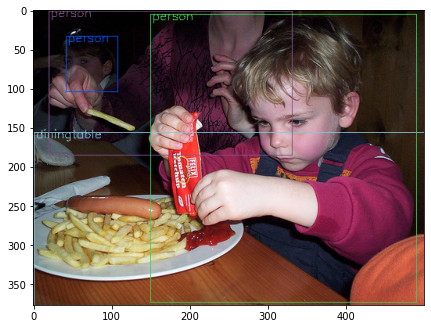

In [7]:
draw_bbox(image, boxes, names)

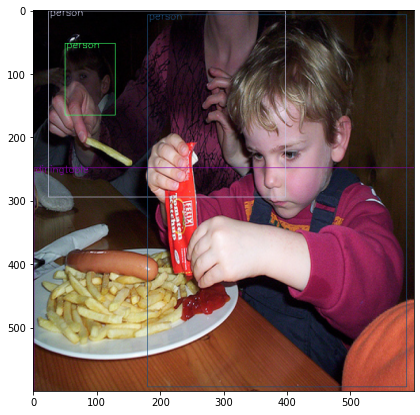

In [8]:
# resize the image to (600, 600, 3)
img = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)
# we have resized the image, so we will also calculate the bouding box accordingly
bxs = recal_bbox(boxes, image.shape, image_size)

draw_bbox(img, bxs, names)

In appendix A of the paper of resnet (https://arxiv.org/abs/1512.03385), the authors mentioned that they took the pretrained resnet101 and

> We compute the full-image shared conv feature maps using those layers whose strides on the image are no greater than 16 pixels (i.e., conv1, conv2 x, conv3 x, and conv4 x, totally 91 conv layers in ResNet-101; Table 1)

That is according to the output(see below) we have to take till `layer3` and the layers `[layer4, avgpool, fc]` will be removed.

In [9]:
resnet101 = torchvision.models.resnet101(pretrained=True)
print(resnet101)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
backbone = Backbone(resnet101)
print(backbone)

Backbone(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [11]:
inp = torch.tensor(np.transpose(img, (2, 0, 1))/255.0).float().unsqueeze(0)
print(inp.shape)
out = backbone.forward(inp)
print(out.shape)

torch.Size([1, 3, 600, 600])
torch.Size([1, 1024, 38, 38])


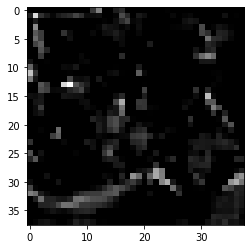

In [12]:
plt.imshow(out.detach().numpy()[0, 0, :, :], cmap="gray")

## ANCHOR GENERATION

As you can see from above, our input was 600 x 600 image and we got 38 x 38 featue map. As per the paper (for 
COCO), authors used 3 aspect ratios and 4 scales that is

$$
A \in \left\{64^2, 128^2, 256^2, 512^2\right\} \\
R \in \left\{1:1, 1:2, 2:1\right\}
$$

It means on each location we will have $ 3 \times 4 = 12 $ anchors at each location. As the feature map is of size $ 38 \times 38 $ it means we will have 1444 locations on the image. These 1444 locations are divided equally 38 in one direction and 38 in other direction.

So the spacing will be $ \frac{600}{38} = 15.78 $  between the locations.

**Our end goal on anchor generation is to create a array of shape (N, 4) where N denotes number of anchors and 4 denotes the (xmin, ymin) and (xmax, ymax) coordinates of anchors**

In [13]:
# spacing in x direction and y direction
feature_map_size = (out.shape[2], out.shape[3])
spx = image_size[1] / feature_map_size[1]
spy = image_size[0] / feature_map_size[0]

In [14]:
# we have find the center of anchor box
# for that find the topleft and then offset by (15.78/2) in both x and y direction

# here xt is x ticks and yt is y ticks
xt = np.arange(0, feature_map_size[1]) * spx
yt = np.arange(0, feature_map_size[0]) * spy

xmin, ymin = np.meshgrid(xt, yt, indexing="xy")
print(xmin.shape)
print(ymin.shape)

# now offset xmin with spx / 2 and ymin with spy / 2 to get anchor center point
cx = xmin + spx / 2
cy = ymin + spy / 2
print(cx.shape, cy.shape)

(38, 38)
(38, 38)
(38, 38) (38, 38)


In [15]:
# if you round off the center - cordinates then we will have x and y as shown below
# this is only for log and visualization purpose.
# we will only round off at the end.
np.round_(cx).astype(np.int64), np.round_(cy).astype(np.int64)

(array([[  8,  24,  39, ..., 561, 576, 592],
        [  8,  24,  39, ..., 561, 576, 592],
        [  8,  24,  39, ..., 561, 576, 592],
        ...,
        [  8,  24,  39, ..., 561, 576, 592],
        [  8,  24,  39, ..., 561, 576, 592],
        [  8,  24,  39, ..., 561, 576, 592]]),
 array([[  8,   8,   8, ...,   8,   8,   8],
        [ 24,  24,  24, ...,  24,  24,  24],
        [ 39,  39,  39, ...,  39,  39,  39],
        ...,
        [561, 561, 561, ..., 561, 561, 561],
        [576, 576, 576, ..., 576, 576, 576],
        [592, 592, 592, ..., 592, 592, 592]]))

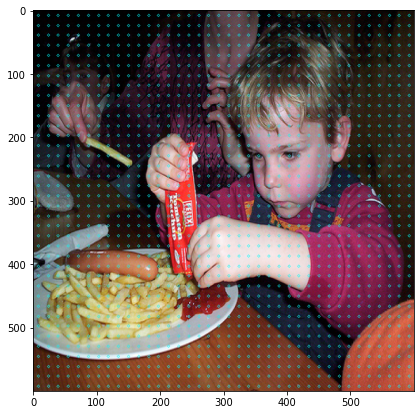

In [16]:
draw_anchor_centers(img, np.round_(cx).astype(np.int64), np.round_(cy).astype(np.int64))

The above are anchor centers. There are $ 38 \times 38 = 1444 $ anchors. Now having the anchor centers we have to know the height and width of each anchor. This is where aspect ratio and scale come in. For each center, there will be 12 boxes with different width and height. So there will be totally $ 1444 \times 12 = 17328 $ anchors

In [17]:
# now stack cx, cy to get center co-ordinates of all 1444 anchors
# where first column denotes x and second column denotes y
center = np.stack([cx.flatten(), cy.flatten()], axis=1)
# here hw denotes height and width of anchors where first column is height and second column is width
hw = get_anchor_height_width(areas, aspect_ratios)
print(center.shape, hw.shape)
print("Center")
print(center)
print("Height and width")
print(hw)

(1444, 2) (12, 2)
Center
[[  7.89473684   7.89473684]
 [ 23.68421053   7.89473684]
 [ 39.47368421   7.89473684]
 ...
 [560.52631579 592.10526316]
 [576.31578947 592.10526316]
 [592.10526316 592.10526316]]
Height and width
[[ 64.          64.        ]
 [128.         128.        ]
 [256.         256.        ]
 [512.         512.        ]
 [ 45.254834    90.50966799]
 [ 90.50966799 181.01933598]
 [181.01933598 362.03867197]
 [362.03867197 724.07734394]
 [ 90.50966799  45.254834  ]
 [181.01933598  90.50966799]
 [362.03867197 181.01933598]
 [724.07734394 362.03867197]]


In [18]:
# now that we have center and height and width of anchors
# the co-ordinates of anchor box will be (cx - w/2, cy - h/2, cx + w/2, cx + h/2)
offset = hw / 2
# run each command seperately to see what is happening here.
# remeber the final output is (17328, 4)
outx = np.meshgrid(offset[:, 1], center[:, 0])
outy = np.meshgrid(offset[:, 0], center[:, 1])

xmin = (outx[1] - outx[0]).flatten()
xmax = (outx[1] + outx[0]).flatten()

ymin = (outy[1] - outy[0]).flatten()
ymax = (outy[1] + outy[0]).flatten()

anchors = np.round_(np.stack([xmin, ymin, xmax, ymax], axis=1)).astype(np.int64)
print(anchors.shape)
print("Anchors")
anchors

(17328, 4)
Anchors


array([[ -24,  -24,   40,   40],
       [ -56,  -56,   72,   72],
       [-120, -120,  136,  136],
       ...,
       [ 547,  502,  637,  683],
       [ 502,  411,  683,  773],
       [ 411,  230,  773,  954]])

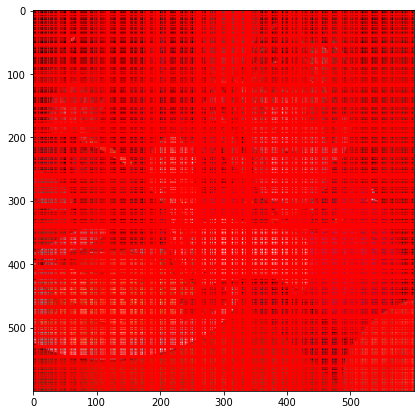

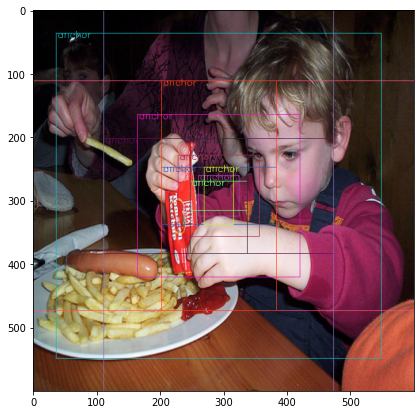

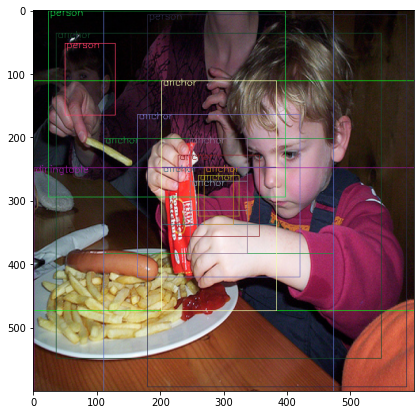

In [19]:
draw_bbox(img, anchors, names=[""]*17328, random=False)
draw_bbox(img, anchors[8424 : 8424 + 12], names=["anchor"]*12)
draw_bbox(img, np.vstack((anchors[8424: 8424 + 12, :], bxs)), names=["anchor"]*12 + names)

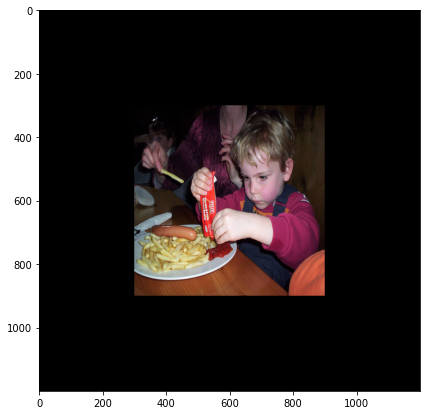

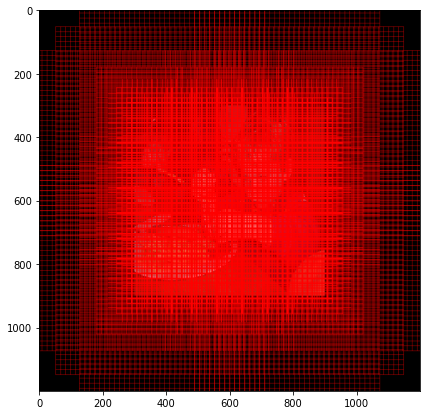

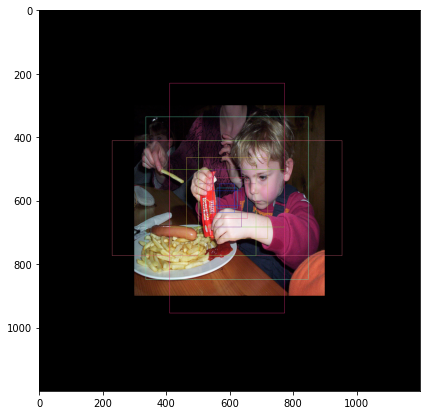

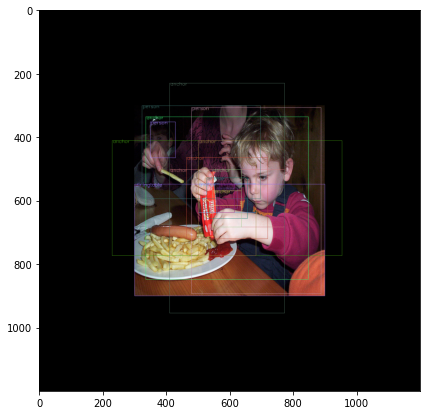

In [20]:
draw_bbox(np.pad(img, ((300, 300), (300, 300), (0, 0)), "constant", constant_values=0), [], [])
draw_bbox(np.pad(img, ((300, 300), (300, 300), (0, 0)), "constant", constant_values=0), anchors + 300, names=[""]*17328, random=False)
draw_bbox(np.pad(img, ((300, 300), (300, 300), (0, 0)), "constant", constant_values=0), anchors[8424 : 8424 + 12] + 300, names=[""]*12)
draw_bbox(np.pad(img, ((300, 300), (300, 300), (0, 0)), "constant", constant_values=0), np.vstack((anchors[8424: 8424 + 12, :], bxs)) + 300, names=["anchor"]*12 + names)

### TRAINING RPN

As per the paper

> The anchor boxes that cross image boundaries need to be handled with care. During training, we ignore
all cross-boundary anchors so they do not contribute to the loss. If the boundary-crossing outliers are not ignored in training, they introduce large, difficult to correct error terms in the objective, and training does not converge.

So we will find the valid anchors from the 17328 anchors

In [21]:
valid_anchors_index = np.where(
    (anchors[:, 0] >= 0) &
    (anchors[:, 1] >= 0) &
    (anchors[:, 2] <= image_size[1]) &
    (anchors[:, 3] <= image_size[0])
)

valid_anchors = anchors[valid_anchors_index]
print(valid_anchors.shape)
print("Valid Anchors")
valid_anchors

(7376, 4)
Valid Anchors


array([[ 10,   1, 101,  46],
       [ 26,   1, 116,  46],
       [ 42,   1, 132,  46],
       ...,
       [468, 554, 558, 599],
       [484, 554, 574, 599],
       [499, 554, 590, 599]])

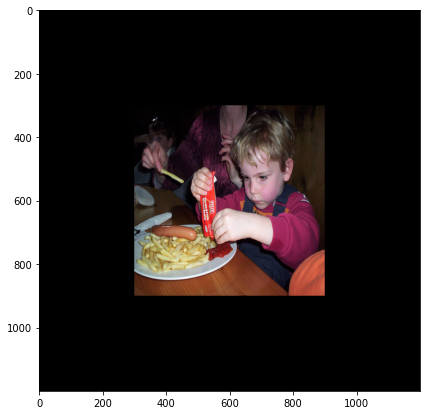

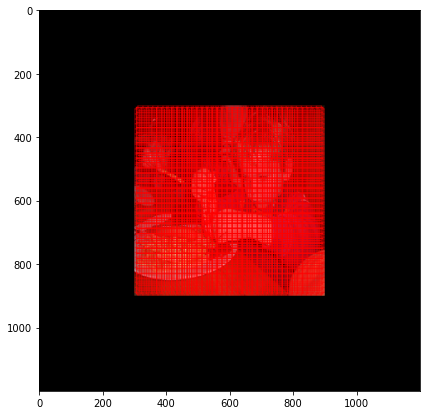

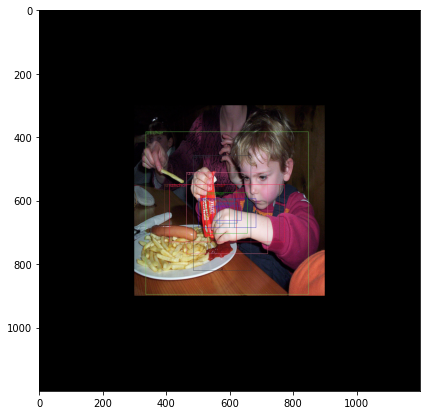

In [22]:
draw_bbox(np.pad(img, ((300, 300), (300, 300), (0, 0)), "constant", constant_values=0), [], [])
draw_bbox(np.pad(img, ((300, 300), (300, 300), (0, 0)), "constant", constant_values=0), valid_anchors + 300, names=[""]*17000, random=False)
draw_bbox(np.pad(img, ((300, 300), (300, 300), (0, 0)), "constant", constant_values=0), valid_anchors[4324: 4324+12, :] + 300, names=["anchor"]*12)


So out of 17328, 7376 (42.56 %) anchors are valid. So now we have to find the out of 7376, which one are positive and which are negative and which should be ignored while training. Before going ahead what we will do is find the `box_iou` between valid anchors and ground truth box

In [23]:
gt_iou = box_iou(valid_anchors, bxs)
print(gt_iou.shape)

(7376, 4)


Now that we have `iou` with between ground truth and valid anchors. As per the paper

For each anchor assign a positive label for
- The anchor/anchors with the highest IoU overlap with a ground-truth box
- An anchor that has IoU overlap higher than 0.7 with any ground-truth-box

go through the remaining anchors and assign a negative label if

- IoU is less than 0.3 for all ground-truth box

The remaining anchors even after this step are ignored while training.

In [24]:
# copied from : https://github.com/pytorch/vision/blob/f56e6f63aa1d37e648b0c4cb951ce26292238c53/torchvision/models/detection/_utils.py#L358-L396

# we have to return a 7376 array where each element is a number from 0 to 3 
# (4 - 1 where 4 is number of ground-truth box in the image)
# if the anchor is negative, the array should contain -1
# if the anhor is ignored then array should contain -2

# matches -> (7364,) array
# first we will apply rule 2 and rule 3.
# rule 2 says if any of ground-truth is greater than 0.7 then we have to take it positive (match it with highest IoU)
# so if the maximum value with all the ground-truth is greater than 0.7, then we take it positive and assign it.
# same kind of argument goes with rule 3 as well
# for the start, we will assume that every anchor is positive and matched
matches = np.argmax(gt_iou, axis=1)
# make of copy of matches. the reason is below
all_matches = np.copy(matches)

# the maximum values
matched_vals = gt_iou[np.arange(0, len(gt_iou)), matches]

# if the max value is less than 0.3 (bg_iou_threshold)
below_low_threshold = matched_vals < bg_iou_threshold

# these are ignored values
between_thresholds = (matched_vals >= bg_iou_threshold) & (matched_vals < fg_iou_threshold)

matches[below_low_threshold] = -1
matches[between_thresholds] = -2

# now that we are done, we will apply the rule 1 to find more positive anchors
# find the maximum value of IoU per ground-truth
max_iou_per_gt = np.max(gt_iou, axis=0)
# will give tuple with row and column indices
ridx, cidx = np.where(gt_iou == max_iou_per_gt[None, :])
matches[ridx] = all_matches[ridx]
print("Matches shape = {}".format(matches.shape))
print("Stats")
np.unique(matches, return_counts=True)

Matches shape = (7376,)
Stats


(array([-2, -1,  0,  1,  2,  3]), array([ 758, 6603,    3,    3,    1,    8]))

Now that we have positive, negative and ignored proposals, we can calculate the RPN loss. Before that we will construct the RPN network.

We have a featue map of (38, 38, 1024). First we apply a 3x3 (`n = 3` as per the paper) convolution with `padding=1` and `stride=1`. After this we will have two 1x1 convolution layers where the first one will be of $12x2 = 24$ channels representing the proposal classifier and second one will be of $12x4 = 48$

In [30]:
rpn = RegionProposalNetwork(n=3, channels=out.shape[1], k=hw.shape[0])
rpn

RegionProposalNetwork(
  (conv): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cls): Conv2d(256, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (reg): Conv2d(256, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

In [31]:
cls, reg = rpn.forward(out)
print("Classification scores = {}".format(cls.shape))
print("Regression offsets = {}".format(reg.shape))

Classification scores = torch.Size([1, 24, 38, 38])
Regression offsets = torch.Size([1, 48, 38, 38])


In [33]:
anchors[:12][0]

array([[ -24,  -24,   40,   40],
       [ -56,  -56,   72,   72],
       [-120, -120,  136,  136],
       [-248, -248,  264,  264],
       [ -37,  -15,   53,   31],
       [ -83,  -37,   98,   53],
       [-173,  -83,  189,   98],
       [-354, -173,  370,  189],
       [ -15,  -37,   31,   53],
       [ -37,  -83,   53,   98],
       [ -83, -173,   98,  189],
       [-173, -354,  189,  370]])

In [34]:
anchors[12:24]

array([[  -8,  -24,   56,   40],
       [ -40,  -56,   88,   72],
       [-104, -120,  152,  136],
       [-232, -248,  280,  264],
       [ -22,  -15,   69,   31],
       [ -67,  -37,  114,   53],
       [-157,  -83,  205,   98],
       [-338, -173,  386,  189],
       [   1,  -37,   46,   53],
       [ -22,  -83,   69,   98],
       [ -67, -173,  114,  189],
       [-157, -354,  205,  370]])

In [36]:
center

(1444, 2)